Question 1

In [1]:
import numpy as np

In [2]:
# helper activation function
def activation(x):
    return np.tanh(x)

# helper loss function
def logistic_loss(y, f):
    return -f[y] + np.log(np.sum(np.exp(f)))

def prediction_loss(x,y,W,V,b,c):
    # do stuff here

    # activation function on the dot product of (x and W) + b
    res = activation(np.dot(W,x) + b)

    # dot product of res and V and add c
    f = np.dot(V, res) + c

    # calculate the loss
    L = logistic_loss(y, f)
    return L.squeeze()

Question 2

In [3]:
def prediction_grad(x,y,W,V,b,c):
    # do stuff here
    f = np.dot(V, np.tanh(np.dot(W,x) + b)) + c

    unit_vector = np.zeros(f.shape) # create a zero vector of the same shape as f
    unit_vector[y] = 1 # set the yth element to 1 to set the unit vector in the y dim

    dLdf = -unit_vector + np.exp(f) / np.sum(np.exp(f)) 
    
    dLdc = dLdf

    # gradient of loss function relative to V
    a = np.tanh(np.dot(W,x) + b)
    dLdV = np.outer(dLdf, a.T)

    # gradient of loss function relative to b
    sigma_prime = 1 - a**2
    dLdb = sigma_prime * np.dot(V.T, dLdf)

    # gradient of loss function relative to W
    dLdW = np.outer(sigma_prime * np.dot(V.T, dLdf), x.T)


    return dLdW, dLdV, dLdb, dLdc

Question 3

In [4]:
x = np.array([1, 2])
y = 1
W = np.array([[.5, -1],
              [-.5, 1],
              [1, .5]])
V = np.array([[-1, -1, 1],
              [1, 1, 1]])
b = np.array([0, 0, 0])
c = np.array([0, 0])

dLdW, dLdV, dLdb, dLdc = prediction_grad(x,y,W,V,b,c)
print("dLdW:", dLdW)
print("dLdV:", dLdV)
print("dLdb:", dLdb)
print("dLdc:", dLdc)


dLdW: [[-0.18070664 -0.36141328]
 [-0.18070664 -0.36141328]
 [ 0.          0.        ]]
dLdV: [[-0.45257413  0.45257413  0.48201379]
 [ 0.45257413 -0.45257413 -0.48201379]]
dLdb: [-0.18070664 -0.18070664  0.        ]
dLdc: [ 0.5 -0.5]


Question 4

In [5]:
import jax
from jax import numpy as np
from jax import grad

In [6]:
def prediction_grad_jax(x,y,W,V,b,c):
    # do stuff here

    dLdW, dLdV, dLdb, dLdc = grad(prediction_loss, argnums= (2,3,4,5))(x,y,W,V,b,c)
    
    return dLdW, dLdV, dLdb, dLdc

Question 5

In [7]:
# Helper function
def logistic_loss_vectorized(Y, F):

    # Gather the correct class scores for each sample
    correct_class_scores = F[np.arange(len(Y)), Y]

    # Compute the vector of losses for each sample
    losses = -correct_class_scores + np.log(np.sum(np.exp(F), axis=1))

    # Return the total loss (sum over all samples)
    return np.sum(losses)

# Helper function
def vectorized_loss(X,Y,W,V,b,c):
    a = activation(np.dot(X, W.T) + b)
    pred = np.dot(a, V.T) + c
    return logistic_loss_vectorized(Y, pred)


############
# MAIN FUNCTION
############

def prediction_loss_full(X,Y,W,V,b,c,λ):
    # do stuff here

    # X is now 2D array of inputs
    # Y is now 1D array of outputs

    L = vectorized_loss(X,Y,W,V,b,c)

    # add the regularization
    L += λ * (np.sum(W**2) + np.sum(V**2))
    return L.squeeze()  # include regularization

Question 6

In [8]:
def prediction_grad_full(X,Y,W,V,b,c,λ):
    # do stuff here
    # X is now 2D array of inputs
    # Y is now 1D array of outputs

    dLdW, dLdV, dLdb, dLdc = grad(prediction_loss_full, argnums= (2,3,4,5))(X,Y,W,V,b,c,λ)

    return dLdW, dLdV, dLdb, dLdc

Question 7

In [9]:
from matplotlib import pyplot as plt
from numpy import random
import time

M | Training time (ms)
5 | 219740.74411392212
40 | 243588.9778137207
70 | 270961.5559577942


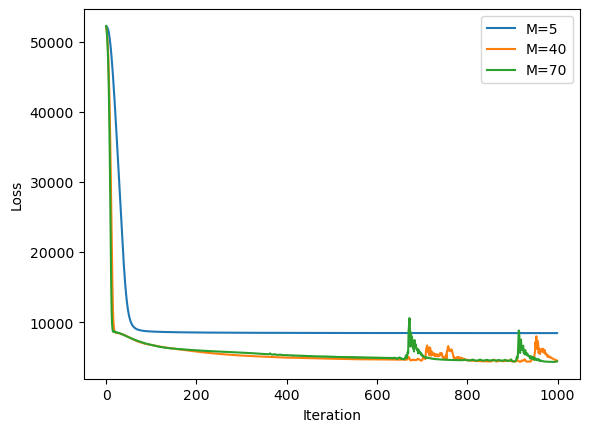

In [10]:
# load data
stuff=np.load("data.npz")
X_trn = stuff["X_trn"]
y_trn = stuff["y_trn"]
X_tst = stuff["X_tst"]
# no Y_tst !

# helper function - training loop
def loss_training_loop(X_trn, y_trn, m, D, iters=1000, λ=1, stepsize=0.000025, momentum=0.1):

    # initialize variables

    W = random.normal(0, 1, (m, D)) / np.sqrt(D)
    V = random.normal(0, 1, (len(y_trn), m)) / np.sqrt(D)
    b = np.zeros(m)
    c = np.zeros(len(y_trn))
    avg_grad_w = 0
    avg_grad_v = 0
    avg_grad_b = 0
    avg_grad_c = 0
    loss_iter = []
    start_time = time.time()

    # training loop
    for i in range(iters):
        # calculate loss
        loss_iter.append(prediction_loss_full(X_trn, y_trn, W, V, b, c, λ)) 

        # calculate gradients
        cur_grad_w, cur_grad_v, cur_grad_b, cur_grad_c = prediction_grad_full(X_trn, y_trn, W, V, b, c, λ)

        # update variables with momentum
        avg_grad_w = (1 - momentum) * avg_grad_w + momentum * cur_grad_w
        avg_grad_v = (1 - momentum) * avg_grad_v + momentum * cur_grad_v
        avg_grad_b = (1 - momentum) * avg_grad_b + momentum * cur_grad_b
        avg_grad_c = (1 - momentum) * avg_grad_c + momentum * cur_grad_c
       
        W = W - stepsize * avg_grad_w
        V = V - stepsize * avg_grad_v
        b = b - stepsize * avg_grad_b
        c = c - stepsize * avg_grad_c

    end_time = time.time()
    print(f"{m} | {(end_time - start_time) * 1000}")

    return loss_iter


#####################
# MAIN CODE
#####################

# reshape X_trn
X_trn = X_trn.reshape(X_trn.shape[0], 2523)

M = [5, 40, 70]
D = X_trn.shape[1]

# given params
iters = 1000
stepsize = .000025
momentum = .1
λ = 1

print("M | Training time (ms)")
for m in M:
    loss  = loss_training_loop(X_trn, y_trn, m, D, iters, λ, stepsize, momentum)
    plt.plot(range(iters), loss, label=f"M={m}")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")

plt.legend()
plt.show()




Question 8

In [11]:
# load data
stuff=np.load("data.npz")
X_trn = stuff["X_trn"]
y_trn = stuff["y_trn"]
X_tst = stuff["X_tst"]
# no Y_tst !

# reshape X_trn
X_trn = X_trn.reshape(X_trn.shape[0], 2523)

# split training data into training and validation
X_trn_trn = X_trn[:len(X_trn)//2]
X_trn_val = X_trn[len(X_trn)//2:]
y_trn_trn = y_trn[:len(y_trn)//2]
y_trn_val = y_trn[len(y_trn)//2:]

# helper function - training loop and return variables
def loss_training_loop_variables(X_trn, y_trn, m, D, iters=1000, λ=1, stepsize=0.000025, momentum=0.1):

    # initialize variables
    W = random.normal(0, 1, (m, D)) / np.sqrt(D)
    V = random.normal(0, 1, (len(y_trn), m)) / np.sqrt(D)
    b = np.zeros(m)
    c = np.zeros(len(y_trn))
    avg_grad_w = 0
    avg_grad_v = 0
    avg_grad_b = 0
    avg_grad_c = 0
    loss_iter = []

    for i in range(iters):

        # calculate loss
        loss_iter.append(prediction_loss_full(X_trn, y_trn, W, V, b, c, λ))

        # calculate gradients
        cur_grad_w, cur_grad_v, cur_grad_b, cur_grad_c = prediction_grad_full(X_trn_trn, y_trn_trn, W, V, b, c, λ)

        # update variables with momentum
        avg_grad_w = (1 - momentum) * avg_grad_w + momentum * cur_grad_w
        avg_grad_v = (1 - momentum) * avg_grad_v + momentum * cur_grad_v
        avg_grad_b = (1 - momentum) * avg_grad_b + momentum * cur_grad_b
        avg_grad_c = (1 - momentum) * avg_grad_c + momentum * cur_grad_c
       
        W = W - stepsize * avg_grad_w
        V = V - stepsize * avg_grad_v
        b = b - stepsize * avg_grad_b
        c = c - stepsize * avg_grad_c

    # return final variables
    return W, V, b, c


def validation_prediction(X_val, y_val, W, V, b, c):

    # evaluate using trained variables
    a = activation(np.dot(X_val, W.T) + b)
    pred = np.dot(a, V.T) + c

    predicted_classes = np.argmax(pred, axis=1) # predicted class for each example

    # calculate classification error
    correct_predictions = sum(predicted_classes == y_val)
    classification_error = 1 - correct_predictions / len(y_val)

    return classification_error

M = [5, 40, 70]
D = X_trn.shape[1]

# given params
iters = 1000
stepsize = .000025
momentum = .1
λ = 1

print("M | classification error")
for m in M:
    final_W, final_V, final_b, final_c = loss_training_loop_variables(X_trn_trn, y_trn_trn, m, D, iters, λ, stepsize, momentum)
    e = validation_prediction(X_trn_val, y_trn_val, final_W, final_V, final_b, final_c)
    print(f"{m} | {e}")


M | classification error
5 | 0.7566666603088379
40 | 0.41633331775665283
70 | 0.359333336353302


In [12]:
# Re-train with best M on full training data
def train_predict_test_data(X_trn, y_trn, X_tst, m, D, iters=1000, λ=1, stepsize=0.000025, momentum=0.1):
    
    X_trn = X_trn.reshape(X_trn.shape[0], 2523)
    D = X_trn.shape[1]

    # given params
    iters = 1000
    stepsize = .000025
    momentum = .1
    λ = 1

    # best M from previous step
    m = 70

    # train with full training data
    W, V, b, c = loss_training_loop_variables(X_trn, y_trn, m, D, iters, λ, stepsize, momentum)

    # predict on test data
    a = activation(np.dot(X_tst, W.T) + b)
    pred = np.dot(a, V.T) + c
    predicted_classes = np.argmax(pred, axis=1) # predicted class for each example

    return predicted_classes




In [13]:
# import numpy as np
import csv

def write_csv(y_pred, filename):
    """Write a 1d numpy array to a Kaggle-compatible .csv file"""
    with open(filename, 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Id', 'Category'])
        for idx, y in enumerate(y_pred):
            csv_writer.writerow([idx, y])


data = np.load('data.npz')
X_trn = data['X_trn'].reshape(X_trn.shape[0], 2523)
y_trn = data['y_trn']
X_tst = data['X_tst'].reshape(X_tst.shape[0], 2523)
y_pred = train_predict_test_data(X_trn, y_trn, X_tst, m, D, iters, λ, stepsize, momentum)
write_csv(y_pred, 'submission.csv')

REPORT:

m value = 70 \
generalization error = 0.359333336353302